In [8]:
#LIBRARIES
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import json
import time
from datetime import datetime
import pydde as dde
import os

#PARAMETERS
now = datetime.now()
samplenum = 10
nTimeSteps = 60 #at 60Hz
batch_size = 2
input_size = 9 # q (0:3), qdot (3:6), current p (9:12) 
#samples_per_sim = int(nTimeSteps/6) # amount of states taken per generated trajectory
samples_per_sim = 4
filenum = int(samplenum/batch_size)
use_case = 'qhold'
sample_file_path = f'../Data/Samples/data_qhold_{nTimeSteps}tsteps_' + now.strftime("%H%M") + '/'
simulation_file_path = "../Data/Simulations/pm_target.sim"
objective_file_path = f'../Data/Objectives/pm_qhold.obj'
objective_file_path_sampling = f'../Data/Objectives/pm_target.obj'

# check dde version
print("using dde version: " + dde.__version__)
# set log level
dde.set_log_level(dde.LogLevel.off)
print(f'log level set to {dde.get_log_level()}')

# CREATE DIRECTORY FOR SAMPLES
try:
    os.mkdir(sample_file_path)
except OSError:
    print ("Creation of the directory %s failed" % sample_file_path)
else:
    print ("Successfully created the directory %s" % sample_file_path)

#SAMPLE TARGETS
print("SAMPLING STARTED...")
'''
n_s = np.floor(samplenum/samples_per_sim).astype(int)

input = np.zeros((samplenum,input_size))
input.shape
targets = np.zeros((n_s,3))
targets[:,0] = np.random.rand(n_s)
targets[:,1] = np.random.rand(n_s)
targets[:,2] = np.random.rand(n_s)
'''
############################################
#LOAD SIMULATION PYDDE_V2
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init_0 = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(nTimeSteps):
	p_init_0[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init_0)
q_0 = dyn.q0
qdot_0 = dyn.qdot0
qddot_0 = dyn.qddot0
r = dyn.r(state_init, p_init_0)
dr = dyn.dr_dp(state_init, p_init_0)
dq = dyn.dq_dp(state_init, p_init_0)

#############################################
#GENERATE OPTIMIZATION
opt = dde.Newton()
opt.maxIterations = 800

#OBJECTIVE
obj = dde.InverseObjective(dyn)
objective_json = json.load(open(objective_file_path))
obj.loadJson(objective_json)

using dde version: 
log level set to LogLevel.off
Successfully created the directory ../Data/Samples/data_qhold_60tsteps_1452/
SAMPLING STARTED...


In [15]:
####################################
#SAMPLE STATES
# q (0:3), qdot (3:6), qddot(6:9), current p (9:12) 
p_init = p_init_0
start_time = time.time()
print("SAMPLING INITIAL STATES...")
dyn_json = json.load(open(simulation_file_path))
objective_json = json.load(open(objective_file_path_sampling))
'''
for i in range(n_s):
    #load objective
    obj = dde.InverseObjective(dyn)
    objective_json["objectives"]["pmTargetPositions"][0]["timeIndex"] = nTimeSteps-1
    objective_json["objectives"]["pmTargetPositions"][0]["targetPos"][0] = [targets[i,0]]
    objective_json["objectives"]["pmTargetPositions"][0]["targetPos"][1] = [targets[i,1]]
    objective_json["objectives"]["pmTargetPositions"][0]["targetPos"][2] = [targets[i,2]]
    obj.loadJson(objective_json)
    p_i = opt.minimize(obj, p_init)
    residual = obj.evaluate(p_i)
    print(residual)

    #Trajectory Optimization
    g = 0
    residual = 1
    while residual > 0.001:
        p_i = opt.minimize(obj, p_init)
        p_init = p_i
        #print(f'iteration{g} with residual {opt.lastResidual}')
        g = g+1
        if g == 150:
            #change starting position to initial position
            dyn = dde.DynamicSequence()
            dyn.loadFile(simulation_file_path, nTimeSteps)
            p_init = p_init_0
            obj = dde.InverseObjective(dyn)
            objective_json["objectives"]["pmTargetPositions"][0]["timeIndex"] = nTimeSteps-1
            objective_json["objectives"]["pmTargetPositions"][0]["targetPos"][0] = [targets[i,0]]
            objective_json["objectives"]["pmTargetPositions"][0]["targetPos"][1] = [targets[i,1]]
            objective_json["objectives"]["pmTargetPositions"][0]["targetPos"][2] = [targets[i,2]]          
            obj.loadJson(objective_json)
        if g == 250:
            break
        residual = obj.evaluate(p_i)
    print(residual)
    print(g)

    state_i = dyn.q(p_i)
    n_q = np.floor(dyn.nDofs*nTimeSteps/samples_per_sim).astype(int)
    n_p = np.floor(dyn.nParameters*nTimeSteps/samples_per_sim).astype(int)
    
    for s in range(samples_per_sim):
        s_ = s+1
        input[i*samples_per_sim+s,0:3] = state_i.q[n_q*s_- dyn.nDofs:n_q*s_]
        input[i*samples_per_sim+s,3:6] = state_i.qdot[n_q*s_- dyn.nDofs:n_q*s_]
        input[i*samples_per_sim+s,6:9] = state_i.qddot[n_q*s_- dyn.nDofs:n_q*s_]
        input[i*samples_per_sim+s,9:12] = p_i[n_p*s_- dyn.nParameters:n_p*s_]

    for l in range(dyn.nDofs):
        dyn_json["simulation"]["q"][l] = [input[i*samples_per_sim+s,0+l]]
        dyn_json["simulation"]["qdot"][l] = [input[i*samples_per_sim+s,3+l]]
        dyn_json["simulation"]["qddot"][l] = [input[i*samples_per_sim+s,6+l]]
    for l in range(dyn.nParameters):
        dyn_json["simulation"]["p"][l] = [input[i*samples_per_sim+s,9+l]]
    dyn.loadJson(dyn_json, nTimeSteps)
    dyn.p0 = input[i*samples_per_sim,9:12]
    for s_1 in range(nTimeSteps):
        p_init[s_1*dyn.p0.size : (s_1+1)*dyn.p0.size] = dyn.p0
    if i%(n_s/5) == 0:
        print(f'{(time.time() - start_time)/60} simulation number {i+1} complete')

print(f'TOTAL TIME TO SAMPLE STARTIG STATES: {(time.time() - start_time)/60}')
'''
input = np.zeros((samplenum,input_size))
# sample q
input[:,0] = np.random.rand(samplenum)
input[:,1] = np.random.rand(samplenum)
input[:,2] = np.random.rand(samplenum)
# sample qdot
input[:,3] = np.random.rand(samplenum)
input[:,4] = np.random.rand(samplenum)
input[:,5] = np.random.rand(samplenum)
# sample p_now
input[:,6] = np.random.rand(samplenum)*2
input[:,7] = np.random.rand(samplenum)*2
input[:,8] = np.random.rand(samplenum)*2
print(f'TOTAL TIME TO SAMPLE STARTIG STATES: {(time.time() - start_time)/60}')

SAMPLING INITIAL STATES...
TOTAL TIME TO SAMPLE STARTIG STATES: 0.0002640525499979655


In [16]:
###############################################
#SAMPLE CONTROLS
c=0 # counter for how often the error is too high

for b in range(filenum):
    data = {}
    data['p'] = []
    data['q_target'] = []
    data['q'] = []
    data['qdot'] = []
    #data['qddot'] = []
    data['p_now'] = []
    data['loss'] = []
    for i in range(batch_size):
        #Change DynamicSequence
        for l in range(dyn.nDofs):
            dyn_json["simulation"]["q"][l] = [input[b*batch_size+i,0+l]] 
            dyn_json["simulation"]["qdot"][l] = [input[b*batch_size+i,3+l]] 
            #dyn_json["simulation"]["qddot"][l] = [input[b*batch_size+i,6+l]] 
        for l in range(dyn.nParameters):
            dyn_json["simulation"]["p"][l] = [input[b*batch_size+i,6+l]] 
        dyn.loadJson(dyn_json, nTimeSteps)
        dyn.p0 = input[b*batch_size+i,6:9]
        for s in range(nTimeSteps):
            p_init[s*dyn.p0.size : (s+1)*dyn.p0.size] = dyn.p0

        #Trajectory Optimization
        g = 0
        residual = 1
        while residual > 0.001:
            p_i = opt.minimize(obj, p_init)
            p_init = p_i
            #print(f'iteration{g} with residual {opt.lastResidual}')
            g = g+1
                
            if g == 3:
                c = c+1
                break
            residual = obj.evaluate(p_i)

        #Store the Data
        data['q'].append(list(input[b*batch_size+i,0:3]))
        data['qdot'].append(list(input[b*batch_size+i,3:6]))
        #data['qddot'].append(list(input[b*batch_size+i,6:9]))
        data['p_now'].append(list(input[b*batch_size+i,6:9]))
        data['p'].append(list(p_i))
        data['loss'].append(residual)

    with open(sample_file_path + f'data_{b}.json', 'w') as outfile:
        json.dump(data, outfile)
    print(f'batch number {b+1} completed')
    print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed
    
#add description file
Description = {}
Description['Description'] = [{'samplenum': samplenum, 'samplesperfile': batch_size, 'time length': nTimeSteps, 'sample space': "x-, y- and z direction 0 to 1"}]
with open(sample_file_path + 'Description.json', 'w') as outfile:
    json.dump(Description, outfile)
print('SAMPLING COMPLETE.')
print(f'Jumped to initial state due to high error {c} times')
print(f'TOTAL TIME TO SAMPLE: {(time.time() - start_time)/60}')

batch number 1 completed

Duration: 0.275 min
batch number 2 completed

Duration: 0.281 min
batch number 3 completed

Duration: 0.293 min
batch number 4 completed

Duration: 0.310 min
batch number 5 completed

Duration: 0.345 min
SAMPLING COMPLETE.
Jumped to initial state due to high error 10 times
TOTAL TIME TO SAMPLE: 0.3445965528488159


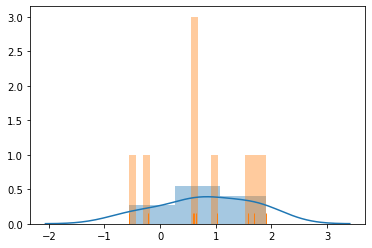

In [13]:
###############################
#PLOT DISTRIBUTION
import seaborn as sns
x = input[5, :]
sns.distplot(x)
sns.distplot(x, bins=20, kde=False, rug=True)